In [1]:
import jax.numpy as jnp
import jax
import jax.random as jr

from optimizers.gd import SGDState, sgd_step

from optimizers.mrcg import MRCGState, mrcg_step

from optimizers.adamw import adamw_init, adamw_step

from optimizers.HB import hb_init, hb_step

from optimizers.NES import nes_init, nes_step

from optimizers.LS_GD import ls_init, ls_step

import matplotlib.pyplot as plt
from model_zoo import rosenbrock_loss, beale_loss

## Model Definition

In [4]:
initial_params = jnp.array([1.0, 2.0, 3.0])

def model(params, x):
    return x[:, 0] **2 * params[0] + x[:, 1] * params[1] + x[:, 2] * params[2]

def loss(y_pred, y_true):
    return jnp.mean((y_pred - y_true) ** 2)
x = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y_true = jnp.array([[1.0], [2.0]])

def loss_at_params(params, key=None):
    y_pred = model(params, x)
    return loss(y_pred, y_true)


In [5]:
def harder_model(params, x):
    return (
        jnp.sin(x[:, 0] * params[0]) +
        jnp.exp(-x[:, 1] * params[1]) +
        (x[:, 2] ** 2) * params[2] * jnp.sin(params[2])
    )

x = jnp.array([
        [1.0, 2.0, 3.0],
        [1.0, 5.0, -2.0],
        [0.0, 14.0, 3.0],
        [3.0, 2.0, 8.0]
        ])

## Optimizers Comparison

In [6]:
def iterate_alg(max_iters, initial_state, step_fn, verbose=False) -> list:
    losses = []
    state = initial_state
    key = jr.PRNGKey(0)
    for i in range(max_iters):
        key, subkey = jr.split(key)
        loss = state.loss_at_params(state.params, subkey)
        losses.append(loss)

        state = step_fn(state)
        if verbose:
            print(f"Iteration {i}: Loss = {loss} Params = {state.params}")
    return losses

Iteration 0: Loss = 14379.93359375 Params = [11.556675   7.4605503]
Iteration 1: Loss = 12593.3837890625 Params = [11.138215  6.869112]
Iteration 2: Loss = 11043.29296875 Params = [10.7429285  6.3221335]
Iteration 3: Loss = 9697.4375 Params = [10.369246  5.816324]
Iteration 4: Loss = 8528.05859375 Params = [10.015709   5.3486366]
Iteration 5: Loss = 7511.228515625 Params = [9.680966  4.9162474]
Iteration 6: Loss = 6626.32373046875 Params = [9.363763 4.516542]
Iteration 7: Loss = 5855.560546875 Params = [9.062935 4.147098]
Iteration 8: Loss = 5183.60009765625 Params = [8.7774    3.8056724]
Iteration 9: Loss = 4597.2080078125 Params = [8.506155  3.4901872]
Iteration 10: Loss = 4084.9658203125 Params = [8.248268  3.1987178]
Iteration 11: Loss = 3637.01220703125 Params = [8.002873 2.929482]
Iteration 12: Loss = 3244.8330078125 Params = [7.7691665 2.680828 ]
Iteration 13: Loss = 2901.072021484375 Params = [7.546401  2.4512272]
Iteration 14: Loss = 2599.371826171875 Params = [7.3338833 2.239

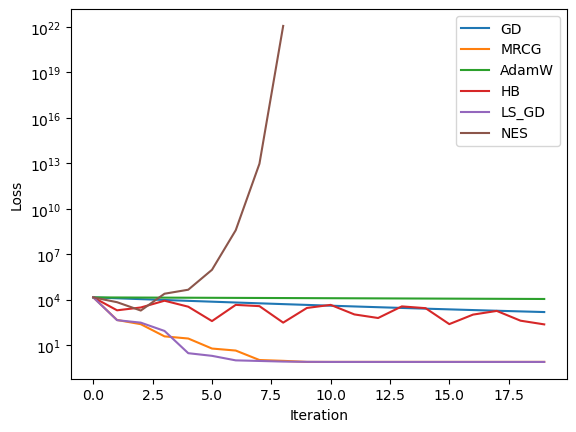

In [7]:
def plot_alg_comparison(ro, initial_params, max_iters=20):
    key = jr.PRNGKey(0)
    sgd_losses = iterate_alg(
        max_iters,
        SGDState(
            initial_params,
            loss_at_params,
            0.0005,
            key,
        ),
        sgd_step,
        verbose=True
    )


    mrcg_losses = iterate_alg(
        max_iters,
        MRCGState(initial_params, loss_at_params, key),
        mrcg_step,
        verbose=True
    )

    adamw_losses = iterate_alg(                   # NEW
            max_iters,
            adamw_init(                                # NEW – helper builds the state
                initial_params,
                loss_at_params,
                0.05,                        # typical LR for AdamW
                key,
            ),
            adamw_step,                                # NEW
            verbose=True
        )
    
    hb_losses = iterate_alg(                   # NEW
        max_iters,
        hb_init(                                # NEW – helper builds the state
            initial_params,
            loss_at_params,
            0.005,                        # typical LR for AdamW
            key,
        ),
        hb_step,                                # NEW
        verbose=True
    )

    ls_losses = iterate_alg(                   # NEW
        max_iters,
        ls_init(                                # NEW – helper builds the state
            initial_params,
            loss_at_params,
            key,
        ),
        ls_step,                                # NEW
        verbose=True
    )

    nes_losses = iterate_alg(                   # NEW
        max_iters,
        nes_init(                                # NEW – helper builds the state
            initial_params,
            loss_at_params,
            0.001,                        # typical LR for AdamW
            key,
        ),
        nes_step,                                # NEW
        verbose=True
    )

    plt.plot(sgd_losses, label='GD')
    plt.plot(mrcg_losses, label='MRCG')
    plt.plot(adamw_losses, label='AdamW')
    plt.plot(hb_losses, label='HB')
    plt.plot(ls_losses, label='LS_GD')
    plt.plot(nes_losses, label='NES')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')

plot_alg_comparison(rosenbrock_loss, jnp.array([12, 8.1]), max_iters=20)

Iteration 0: Loss = 14379.93359375 Params = [11.556675   7.4605503]
Iteration 1: Loss = 12593.3837890625 Params = [11.138215  6.869112]
Iteration 2: Loss = 11043.29296875 Params = [10.7429285  6.3221335]
Iteration 3: Loss = 9697.4375 Params = [10.369246  5.816324]
Iteration 4: Loss = 8528.05859375 Params = [10.015709   5.3486366]
Iteration 5: Loss = 7511.228515625 Params = [9.680966  4.9162474]
Iteration 6: Loss = 6626.32373046875 Params = [9.363763 4.516542]
Iteration 7: Loss = 5855.560546875 Params = [9.062935 4.147098]
Iteration 8: Loss = 5183.60009765625 Params = [8.7774    3.8056724]
Iteration 9: Loss = 4597.2080078125 Params = [8.506155  3.4901872]
Iteration 10: Loss = 4084.9658203125 Params = [8.248268  3.1987178]
Iteration 11: Loss = 3637.01220703125 Params = [8.002873 2.929482]
Iteration 12: Loss = 3244.8330078125 Params = [7.7691665 2.680828 ]
Iteration 13: Loss = 2901.072021484375 Params = [7.546401  2.4512272]
Iteration 14: Loss = 2599.371826171875 Params = [7.3338833 2.239

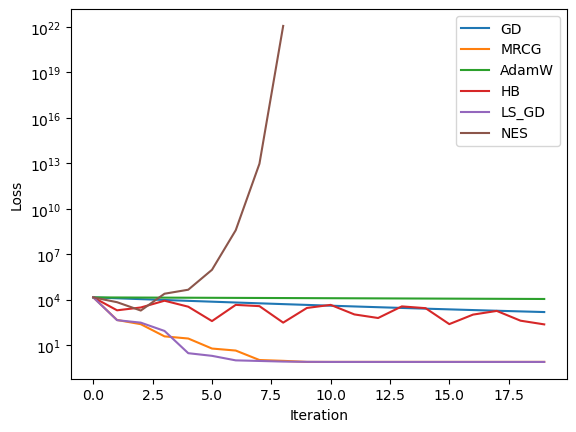

In [8]:
plot_alg_comparison(beale_loss, jnp.array([12, 8.1]), max_iters=20)

## Stochastic

In [9]:
def make_stochastic_mse_loss(x_data: jnp.ndarray, y_data: jnp.ndarray, batch_size: int):
    """
    Returns a loss function that computes MSE on a random mini-batch.
    
    Args:
        x_data: shape (N, D)
        y_data: shape (N,)
        batch_size: int

    Returns:
        loss_fn(params, key): stochastic loss function
    """
    N = x_data.shape[0]

    def loss_fn(params: jnp.ndarray, key: jax.random.PRNGKey) -> jnp.ndarray:
        idx = jax.random.choice(key, N, shape=(batch_size,), replace=False)
        x_batch = x_data[idx]
        y_batch = y_data[idx]

        preds = x_batch @ params
        return jnp.mean((preds - y_batch) ** 2)

    return loss_fn


Iteration 0: Loss = 2.5 Params = [0.004125 0.008625 0.0045   0.       0.       0.       0.       0.
 0.       0.      ]
Iteration 1: Loss = 2.283905029296875 Params = [0.00802837 0.01666969 0.00871153 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 2: Loss = 2.094834089279175 Params = [0.01172362 0.02417257 0.01265268 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 3: Loss = 1.9293895959854126 Params = [0.01522336 0.0311696  0.01634036 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 4: Loss = 1.7846013307571411 Params = [0.01853945 0.03769441 0.01979042 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 5: Loss = 1.6578736305236816 Params = [0.021683   0.04377836 0.02301771 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 6: Loss = 1.5469379425048828 Params = [0.02466439 0.04945079 0.02603611 0.         0.         0.
 0.       

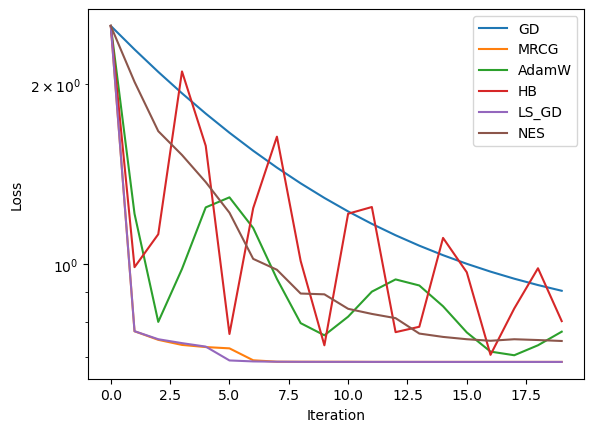

In [10]:
# Generate synthetic data
import jax.random as jr


key = jr.PRNGKey(0)
N, D = 1000, 10
x_data = jr.normal(key, (N, D))
true_w = jnp.arange(1, D + 1)
y_data = x_data @ true_w + 0.1 * jr.normal(key, (N,))

# Create loss function
batch_size = 32
loss_fn = make_stochastic_mse_loss(x_data, y_data, batch_size)

# Initialize parameters and SGD state
init_params = jnp.zeros(D)
plot_alg_comparison(
    loss_fn,
    init_params,
    max_iters=20
)

## Mnist

In [11]:
from models.mnist import loss_at_params, train_accuracy, test_accuracy, flat_params, predict
%reload_ext autoreload
%autoreload 2

init_params = flat_params
init_params.shape

(1863690,)

In [12]:

print(f"Train accuracy: {train_accuracy(init_params):.2f}")
print(f"Validation accuracy: {test_accuracy(init_params):.2f}")

Train accuracy: 0.11
Validation accuracy: 0.11


In [13]:


sgd_losses = iterate_alg(
    100,
    SGDState(
        init_params,
        loss_at_params,
        0.005,
        key,
    ),
    sgd_step,
    verbose=True
)

Iteration 0: Loss = 2.327737808227539 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01486882 -0.00153295
 -0.00921033]
Iteration 1: Loss = 2.3205487728118896 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01511256 -0.00149345
 -0.00954819]
Iteration 2: Loss = 2.356588840484619 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01473639 -0.00142092
 -0.00963652]
Iteration 3: Loss = 2.313422679901123 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01462645 -0.00142842
 -0.0097602 ]
Iteration 4: Loss = 2.267388343811035 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01468438 -0.00139774
 -0.00969846]
Iteration 5: Loss = 2.309391736984253 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01443424 -0.00120912
 -0.00985591]
Iteration 6: Loss = 2.315730333328247 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01414144 -0.00141203
 -0.00978464]
Iteration 7: Loss = 2.279128313064575 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01410311 -0.00157491
 -0.0

In [19]:
def run_and_get_params(max_iters, state, step_fn, **kwargs):
    for _ in range(max_iters):
        state = step_fn(state)        # new state each step
    return state.params               # <- final weights

sgd_state   = MRCGState(init_params, loss_at_params, key)
final_params = run_and_get_params(100, sgd_state, mrcg_step, verbose=True)

print(f"Train accuracy:      {train_accuracy(final_params):.2f}")
print(f"Validation accuracy: {test_accuracy(final_params):.2f}")


Train accuracy:      0.90
Validation accuracy: 0.90


In [14]:

print(f"Train accuracy: {train_accuracy(init_params):.2f}")
print(f"Validation accuracy: {test_accuracy(init_params):.2f}")

Train accuracy: 0.11
Validation accuracy: 0.11


Iteration 0: Loss = 2.327737808227539 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01503611 -0.00171008
 -0.00907913]
Iteration 1: Loss = 2.325039863586426 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01505979 -0.00170563
 -0.00911308]
Iteration 2: Loss = 2.3679726123809814 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01502191 -0.00169773
 -0.00912268]
Iteration 3: Loss = 2.328350305557251 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01500961 -0.0016976
 -0.00913589]
Iteration 4: Loss = 2.285867691040039 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01501385 -0.00169351
 -0.00913085]
Iteration 5: Loss = 2.335627317428589 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01498704 -0.00167341
 -0.0091476 ]
Iteration 6: Loss = 2.3438425064086914 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01495523 -0.00169208
 -0.00914175]
Iteration 7: Loss = 2.3162107467651367 Params = [ 0.00717444 -0.02752596 -0.04403687 ...  0.01494802 -0.00170702
 -0.

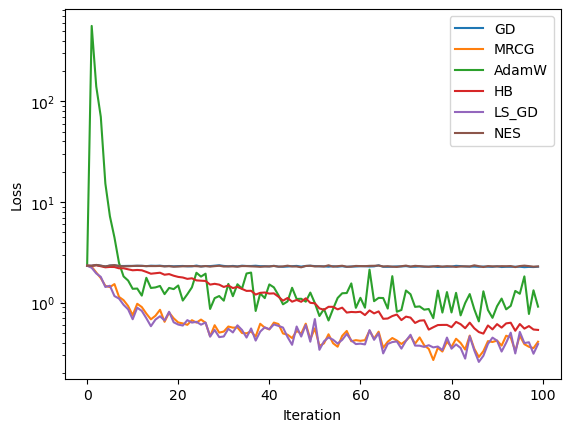

In [29]:
plot_alg_comparison(
    loss_fn,
    init_params,
    max_iters=100
)

## Loss surface path.

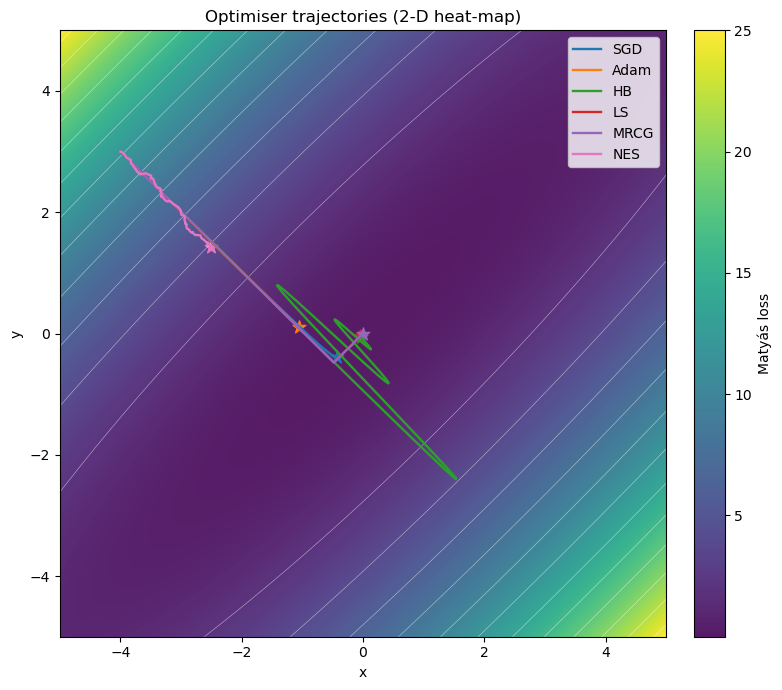

In [ ]:
import jax, jax.numpy as jnp, jax.random as jr, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers "3d" projection

def matyas(params, key=None):
    x, y = params
    return 0.26 * (x**2 + y**2) - 0.48 * x * y

def iterate_alg_with_trace(max_iters, state, step_fn):
    hist = [state.params]
    for _ in range(max_iters):
        state = step_fn(state)
        hist.append(state.params)
    return jnp.stack(hist) 

# available: ["SGD", "Adam", "HB", "LS", "MRCG", "NES"]
optims_to_show = ["SGD", "Adam", "HB", "LS", "MRCG", "NES"]  # any subset
iters          = 60
p0             = jnp.array([-4.0, 3.0])
plot_style     = "2d"      # "2d" or "3d"

optim_registry = {
    "SGD":  (lambda p, f, k: SGDState(p, f, 0.08, k),          sgd_step,  "tab:blue"),
    "Adam": (lambda p, f, k: adamw_init(p, f, 0.06, k),        adamw_step,"tab:orange"),
    "HB":   (lambda p, f, k: hb_init(p, f, 0.08, k, beta=0.9), hb_step,   "tab:green"),
    "LS":   (lambda p, f, k: ls_init(p, f, k),                 ls_step,   "tab:red"),
    "MRCG": (lambda p, f, k: MRCGState(p, f, k),               mrcg_step, "tab:purple"),
    "NES":  (lambda p, f, k: nes_init(p, f, 0.01, k),          nes_step,  "tab:pink"),
}

# sanity: drop any unknown names
optims_to_show = [n for n in optims_to_show if n in optim_registry]

key, *sub = jr.split(jr.PRNGKey(0), len(optims_to_show) + 1)
traces, colours = {}, {}
for i, name in enumerate(optims_to_show):
    init_fn, step_fn, colour = optim_registry[name]
    state        = init_fn(p0, matyas, sub[i])
    traces[name] = iterate_alg_with_trace(iters, state, step_fn)
    colours[name] = colour

x_min, x_max, n_x = -5.0, 5.0, 400
y_min, y_max, n_y = -5.0, 5.0, 400
xs, ys  = jnp.linspace(x_min, x_max, n_x), jnp.linspace(y_min, y_max, n_y)
X, Y    = jnp.meshgrid(xs, ys)
Z       = jax.vmap(matyas)(jnp.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)


if plot_style.lower() == "3d":
    # ---------- 3-D surface with arrows ----------
    fig = plt.figure(figsize=(9, 7))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap="gist_gray_r", edgecolor="none",
                    alpha=0.35, antialiased=True)

    step_skip = 3
    for name, traj in traces.items():
        col = colours[name]
        xs, ys = traj[:, 0], traj[:, 1]
        zs     = jax.vmap(matyas)(traj)
        # arrows every 3 steps (omit the final tiny one)
        for i in range(0, len(traj) - 1 - step_skip, step_skip):
            dx, dy, dz = xs[i+step_skip]-xs[i], ys[i+step_skip]-ys[i], zs[i+step_skip]-zs[i]
            ax.quiver(xs[i], ys[i], zs[i], dx, dy, dz,
                      color=col, linewidth=1.7, arrow_length_ratio=0.15)
        ax.scatter(xs[-1], ys[-1], zs[-1], color=col, marker="*", s=60, label=name)

    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('Loss (Matyás)')
    ax.set_title('Optimiser trajectories (3-D)')
    ax.view_init(elev=35, azim=-60)
    ax.legend()
    plt.show()

else:
    # ---------- 2-D heat-map ----------
    fig, ax = plt.subplots(figsize=(8, 7))
    heat = ax.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin='lower',
                     cmap='viridis', alpha=0.9, interpolation='bilinear')
    plt.colorbar(heat, ax=ax, fraction=0.046, pad=0.04, label='Matyás loss')
    ax.contour(X, Y, Z, levels=15, colors='white', linewidths=0.4, alpha=0.6)

    for name, traj in traces.items():
        xs, ys = traj[:, 0], traj[:, 1]
        ax.plot(xs, ys, '-', color=colours[name], lw=1.7, label=name)
        ax.scatter(xs[-1], ys[-1], marker='*', s=90, color=colours[name])

    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title('Optimiser trajectories (2-D heat-map)')
    ax.legend(loc='upper right')
    plt.tight_layout(); plt.show()


### Note: Use of Rosenbrock loss for path visualization, since for quadratic loss Line Search is same as MRCG

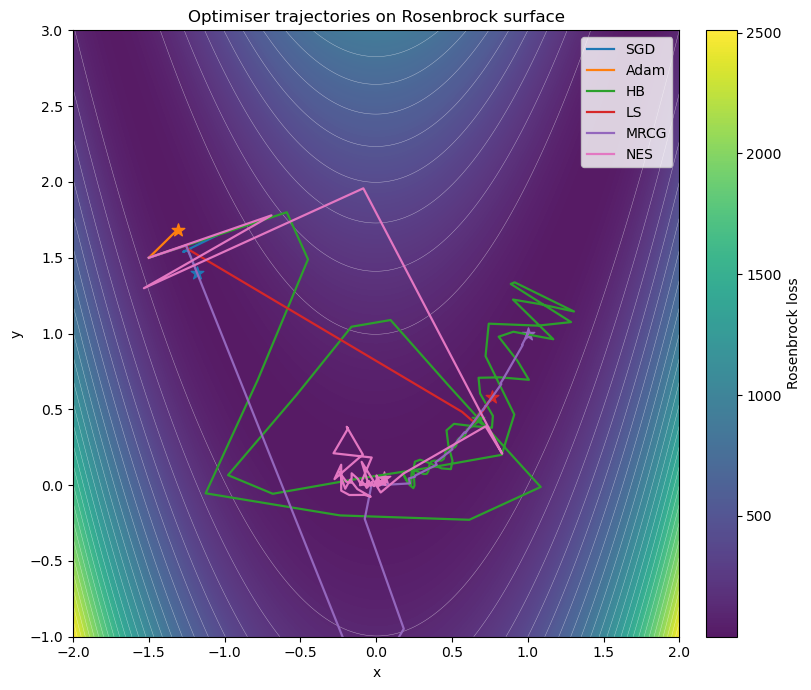

In [2]:
# =================================================================
# 0)  Imports & Rosenbrock loss
# =================================================================
import jax, jax.numpy as jnp, jax.random as jr, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D        # registers "3d" projection

def rosenbrock(params, key=None, a=1.0, b=100.0):
    """
    f(x, y) = (a - x)² + b (y - x²)²
    global min at (a, a²) ==> (1,1) when a=1
    """
    x, y = params
    return (a - x) ** 2 + b * (y - x ** 2) ** 2


# =================================================================
# 1)  Helper to collect parameter history
# =================================================================
def iterate_alg_with_trace(max_iters, state, step_fn):
    hist = [state.params]
    for _ in range(max_iters):
        state = step_fn(state)
        hist.append(state.params)
    return jnp.stack(hist)          # [T+1, 2]


# =================================================================
# 2)  Choose optimisers and settings
# =================================================================
optims_to_show = ["SGD", "Adam", "HB", "LS", "MRCG", "NES"]  # any subset
iters          = 100
p0             = jnp.array([-1.5,  1.5])    # start far from the valley
plot_style     = "2d"                       # "2d" or "3d"

optim_registry = {
    "SGD":  (lambda p, f, k: SGDState(p, f,  0.001, k),         sgd_step,  "tab:blue"),
    "Adam": (lambda p, f, k: adamw_init(p, f, 0.003, k),        adamw_step,"tab:orange"),
    "HB":   (lambda p, f, k: hb_init(p, f,   0.002, k, beta=0.9),hb_step,  "tab:green"),
    "LS":   (lambda p, f, k: ls_init(p, f,  k),                 ls_step,   "tab:red"),
    "MRCG": (lambda p, f, k: MRCGState(p, f, k),                mrcg_step, "tab:purple"),
    "NES":  (lambda p, f, k: nes_init(p, f, 0.002, k),          nes_step,  "tab:pink"),
}

optims_to_show = [n for n in optims_to_show if n in optim_registry]

# =================================================================
# 3)  Run selected optimisers
# =================================================================
key, *sub = jr.split(jr.PRNGKey(0), len(optims_to_show) + 1)
traces, colours = {}, {}
for i, name in enumerate(optims_to_show):
    init_fn, step_fn, colour = optim_registry[name]
    state        = init_fn(p0, rosenbrock, sub[i])
    traces[name] = iterate_alg_with_trace(iters, state, step_fn)
    colours[name] = colour


# =================================================================
# 4)  Prepare Rosenbrock surface grid
# =================================================================
x_min, x_max, n_x = -2.0, 2.0, 400
y_min, y_max, n_y = -1.0, 3.0, 400           # show the banana valley
xs, ys  = jnp.linspace(x_min, x_max, n_x), jnp.linspace(y_min, y_max, n_y)
X, Y    = jnp.meshgrid(xs, ys)
Z       = jax.vmap(rosenbrock)(jnp.stack([X.ravel(), Y.ravel()], axis=1)).reshape(X.shape)


# =================================================================
# 5)  Plot
# =================================================================
if plot_style.lower() == "3d":
    # ---- 3-D surface with arrows ---------------------------------
    fig = plt.figure(figsize=(10, 7))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z,
                    cmap="gist_gray_r", edgecolor="none",
                    alpha=0.35, antialiased=True)

    step_skip = 3
    for name, traj in traces.items():
        col = colours[name]
        xs, ys = traj[:, 0], traj[:, 1]
        zs     = jax.vmap(rosenbrock)(traj)
        for i in range(0, len(traj) - 1 - step_skip, step_skip):
            dx, dy, dz = xs[i+step_skip]-xs[i], ys[i+step_skip]-ys[i], zs[i+step_skip]-zs[i]
            ax.quiver(xs[i], ys[i], zs[i], dx, dy, dz,
                      color=col, linewidth=1.5, arrow_length_ratio=0.15)
        ax.scatter(xs[-1], ys[-1], zs[-1], color=col, marker="*", s=60, label=name)

    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('Loss (Rosenbrock)')
    ax.set_title('Optimiser trajectories on Rosenbrock surface')
    ax.view_init(elev=35, azim=-60)
    ax.legend()
    plt.show()

else:
    # ---- 2-D heat-map --------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 7))
    heat = ax.imshow(Z,
                     extent=(x_min, x_max, y_min, y_max),
                     origin='lower', cmap='viridis',
                     alpha=0.9, interpolation='bilinear')
    plt.colorbar(heat, ax=ax, fraction=0.046, pad=0.04, label='Rosenbrock loss')
    ax.contour(X, Y, Z, levels=25, colors='white', linewidths=0.3, alpha=0.6)

    for name, traj in traces.items():
        xs, ys = traj[:, 0], traj[:, 1]
        ax.plot(xs, ys, '-', color=colours[name], lw=1.6, label=name)
        ax.scatter(xs[-1], ys[-1], marker='*', s=90, color=colours[name])

    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title('Optimiser trajectories on Rosenbrock surface')
    ax.legend(loc='upper right')
    plt.tight_layout(); plt.show()


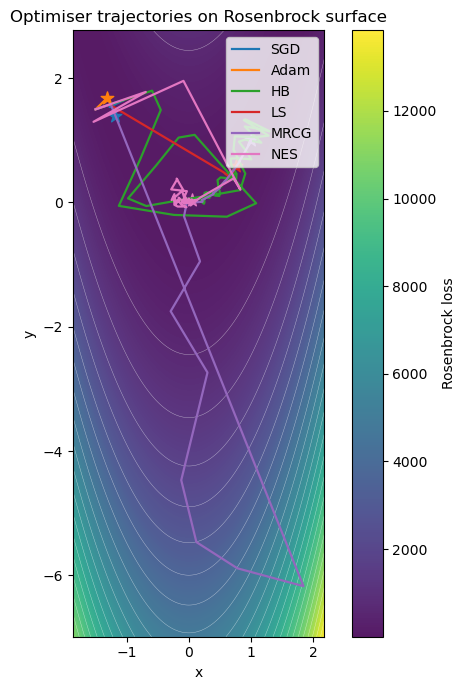

In [3]:
# =================================================================
# 0)  Imports & Rosenbrock loss
# =================================================================
import jax, jax.numpy as jnp, jax.random as jr, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D        # registers "3d" projection

def rosenbrock(params, key=None, a=1.0, b=100.0):
    """
    f(x, y) = (a - x)² + b (y - x²)²
    global min at (a, a²) ==> (1,1) when a=1
    """
    x, y = params
    return (a - x) ** 2 + b * (y - x ** 2) ** 2


# =================================================================
# 1)  Helper to collect parameter history
# =================================================================
def iterate_alg_with_trace(max_iters, state, step_fn):
    hist = [state.params]
    for _ in range(max_iters):
        state = step_fn(state)
        hist.append(state.params)
    return jnp.stack(hist)          # [T+1, 2]


# =================================================================
# 2)  Choose optimisers and settings
# =================================================================
optims_to_show = ["SGD", "Adam", "HB", "LS", "MRCG", "NES"]  # any subset
iters          = 100
p0             = jnp.array([-1.5,  1.5])    # start far from the valley
plot_style     = "2d"                       # "2d" or "3d"

optim_registry = {
    "SGD":  (lambda p, f, k: SGDState(p, f,  0.001, k),         sgd_step,  "tab:blue"),
    "Adam": (lambda p, f, k: adamw_init(p, f, 0.003, k),        adamw_step,"tab:orange"),
    "HB":   (lambda p, f, k: hb_init(p, f,   0.002, k, beta=0.9),hb_step,  "tab:green"),
    "LS":   (lambda p, f, k: ls_init(p, f,  k),                 ls_step,   "tab:red"),
    "MRCG": (lambda p, f, k: MRCGState(p, f, k),                mrcg_step, "tab:purple"),
    "NES":  (lambda p, f, k: nes_init(p, f, 0.002, k),          nes_step,  "tab:pink"),
}

optims_to_show = [n for n in optims_to_show if n in optim_registry]

# =================================================================
# 3)  Run selected optimisers
# =================================================================
key, *sub = jr.split(jr.PRNGKey(0), len(optims_to_show) + 1)
traces, colours = {}, {}
for i, name in enumerate(optims_to_show):
    init_fn, step_fn, colour = optim_registry[name]
    state        = init_fn(p0, rosenbrock, sub[i])
    traces[name] = iterate_alg_with_trace(iters, state, step_fn)
    colours[name] = colour


# =================================================================
# 4)  Prepare Rosenbrock surface grid
# =================================================================
all_xy = jnp.concatenate(list(traces.values()))      # shape [N, 2]
x_vals, y_vals = all_xy[:, 0], all_xy[:, 1]

# take min / max and add 10 % margin
pad = 0.10
x_min, x_max = float(x_vals.min()), float(x_vals.max())
y_min, y_max = float(y_vals.min()), float(y_vals.max())
x_pad = (x_max - x_min) * pad
y_pad = (y_max - y_min) * pad
x_min, x_max = x_min - x_pad, x_max + x_pad
y_min, y_max = y_min - y_pad, y_max + y_pad

# resolution of the mesh
n_x = n_y = 400
xs, ys  = jnp.linspace(x_min, x_max, n_x), jnp.linspace(y_min, y_max, n_y)
X, Y    = jnp.meshgrid(xs, ys)
Z       = jax.vmap(rosenbrock)(
              jnp.stack([X.ravel(), Y.ravel()], axis=1)
          ).reshape(X.shape)

# =================================================================
# 5)  Plot
# =================================================================
if plot_style.lower() == "3d":
    # ---- 3-D surface with arrows ---------------------------------
    fig = plt.figure(figsize=(10, 7))
    ax  = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z,
                    cmap="gist_gray_r", edgecolor="none",
                    alpha=0.35, antialiased=True)

    step_skip = 3
    for name, traj in traces.items():
        col = colours[name]
        xs, ys = traj[:, 0], traj[:, 1]
        zs     = jax.vmap(rosenbrock)(traj)
        for i in range(0, len(traj) - 1 - step_skip, step_skip):
            dx, dy, dz = xs[i+step_skip]-xs[i], ys[i+step_skip]-ys[i], zs[i+step_skip]-zs[i]
            ax.quiver(xs[i], ys[i], zs[i], dx, dy, dz,
                      color=col, linewidth=1.5, arrow_length_ratio=0.15)
        ax.scatter(xs[-1], ys[-1], zs[-1], color=col, marker="*", s=60, label=name)

    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('Loss (Rosenbrock)')
    ax.set_title('Optimiser trajectories on Rosenbrock surface')
    ax.view_init(elev=35, azim=-60)
    ax.legend()
    plt.show()

else:
    # ---- 2-D heat-map --------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 7))
    heat = ax.imshow(Z,
                     extent=(x_min, x_max, y_min, y_max),
                     origin='lower', cmap='viridis',
                     alpha=0.9, interpolation='bilinear')
    plt.colorbar(heat, ax=ax, fraction=0.046, pad=0.04, label='Rosenbrock loss')
    ax.contour(X, Y, Z, levels=25, colors='white', linewidths=0.3, alpha=0.6)

    for name, traj in traces.items():
        xs, ys = traj[:, 0], traj[:, 1]
        ax.plot(xs, ys, '-', color=colours[name], lw=1.6, label=name)
        ax.scatter(xs[-1], ys[-1], marker='*', s=90, color=colours[name])

    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title('Optimiser trajectories on Rosenbrock surface')
    ax.legend(loc='upper right')
    plt.tight_layout(); plt.show()
